In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math

/Library/Python/2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
tree_path = '/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_denv4_tree.json'
freqs_path = '/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_denv4_frequencies.json'

In [3]:
def assign_genotype_attr(tree, mrcas):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in ['genotype', 'genotype_mrca', 'clade_name']}
        
    for genotype, node in mrcas.items():
        node.traits['genotype_mrca'] = True
        node.traits['genotype'] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if 'genotype' in child.traits:
                if genotype != child.traits['genotype']:
                    print 'ERROR: Overlapping genotypes %s and %s at index %s'%(child.traits['genotype'], genotype, child.index)
            child.traits['genotype'] = genotype
    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    tree = bt.loadJSON(path) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})
            color_dict = {}

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

def load_all_frequencies(mrcas, path=freqs_path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')
            clade = split_label[-1]
            clade = mrcas[clade].traits['clade']

            if 'denv' in label:
                region = '_'.join(split_label[:-2])
            else:
                region = '_'.join(split_label[:-1])
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, all_frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for region in all_frequencies.keys():
        for genotype, mrca in mrcas.items():
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[region][genotype] = all_frequencies[region][mrca_clade] 
    return dict(genotype_frequencies)

def make_dataframes(regions, genotype_frequencies, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    region_dfs = {}
    for region in regions:
        region_data = frequencies[region]
        df = pd.DataFrame(region_data, index=pivots)
        df = df.loc[df.index[df.index >= mindate]]
        region_dfs[region] = df
    return region_dfs

In [4]:
tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']

# ['denv2_american', 'denv1_I', ...]
genotypes = tmp['genotypes']

tmp = load_all_frequencies(mrcas)

# {'south_america': 
#         {0: [ 0.2, 0.26, ....]},
#     }
all_frequencies = tmp['frequencies']
frequencies = get_genotype_frequencies(mrcas, all_frequencies) # {'south_america': {'asianI': []}}

# ['south_america', 'southeast_asia']
regions = frequencies.keys()

# [1917., 1918., ...]
pivots = tmp['pivots']

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)

# { 'southeast_asia': pd.DataFrame(columns=genotypes, index=pivots, values=frequencies)}
region_dfs = make_dataframes(regions, frequencies)


Tree height: 157.887820
Tree length: 1678.150570
annotations present

Numbers of objects in tree: 407 (194 nodes and 213 leaves)

ERROR: Overlapping genotypes I and II at index NODE_0000134
ERROR: Overlapping genotypes I and II at index DENV4/CHINA/GD07/1978
ERROR: Overlapping genotypes I and II at index NODE_0000135
ERROR: Overlapping genotypes I and II at index NODE_0000136
ERROR: Overlapping genotypes I and II at index DENV4/INDONESIA/S1228/1978
ERROR: Overlapping genotypes I and II at index DENV4/INDONESIA/AC36/1973
ERROR: Overlapping genotypes I and II at index NODE_0000137
ERROR: Overlapping genotypes I and II at index NODE_0000138
ERROR: Overlapping genotypes I and II at index DENV4/SINGAPORE/06K2270DK1/2005
ERROR: Overlapping genotypes I and II at index NODE_0000139
ERROR: Overlapping genotypes I and II at index DENV4/PHILIPPINES/CN08/2014
ERROR: Overlapping genotypes I and II at index DENV4/CHINA/GZ9809/2012
ERROR: Overlapping genotypes I and II at index NODE_0000140
ERROR: O

In [5]:
print region_dfs['southeast_asia'].head()

             I      II  SYLVATIC
1970.0000  1.0  0.2667    0.3864
1970.0833  1.0  0.2659    0.3878
1970.1667  1.0  0.2652    0.3893
1970.2500  1.0  0.2644    0.3910
1970.3333  1.0  0.2635    0.3927


In [6]:
def plot_region_frequencies(region, dfs = region_dfs, date_range = None, pivots=pivots):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Frequency')

    freqs = dfs[region]
    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for genotype, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[genotype], label=genotype)   
    
def plot_tree():
    branchWidth=2 ## default branch width
    ll = tree
    xmax = max([k.absoluteTime for k in ll.Objects]) + 0.25

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = colors[k.traits['genotype']] if k.traits.has_key('genotype') else 'gray'

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight

            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
#             plt.text(x, y, str(k.traits['clade']), ha='right', zorder=100)
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))


def plot_frequencies_and_tree():
    sns.set(style='whitegrid', font_scale = 1.3)
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(3,3, width_ratios=[1,1,2], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies('global', date_range=[1985., 1995.])
    plt.legend(loc=(2.5,-0.1), title="Dengue Genotypes", fontsize='large')
    globe.set_ylim([0, 1])

    south_america = plt.subplot(gs[1,:-1])
    plot_region_frequencies('south_america',date_range=[1985., 1995.])
    south_america.set_ylim([0, 1])
    
    southeast_asia = plt.subplot(gs[2, :-1])
    plot_region_frequencies('southeast_asia',date_range=[1985., 2014.])
    southeast_asia.set_ylim([0, 1])
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree()
        
    plt.tight_layout()
    plt.show()

In [7]:
def update_mrcas(mrcas=mrcas, tree=tree):
    for genotype, mrca in mrcas.items():
        if not isinstance(mrca, bt.node):
            mrcas[genotype] = [k for k in tree.nodes if k.traits['clade'] == mrca][0]
    genotype_frequencies = get_genotype_frequencies(mrcas, all_frequencies)
    tree = assign_genotype_attr(tree, mrcas)
    region_dfs = make_dataframes(regions, genotype_frequencies)
    return {'frequencies': genotype_frequencies, 'tree': tree, 'region_dfs': region_dfs}

mrcas['I'] = 13
mrcas['SYLVATIC'] = 1

tmp = update_mrcas()
frequencies = tmp['frequencies']
tree = tmp['tree']
region_dfs = tmp['region_dfs']

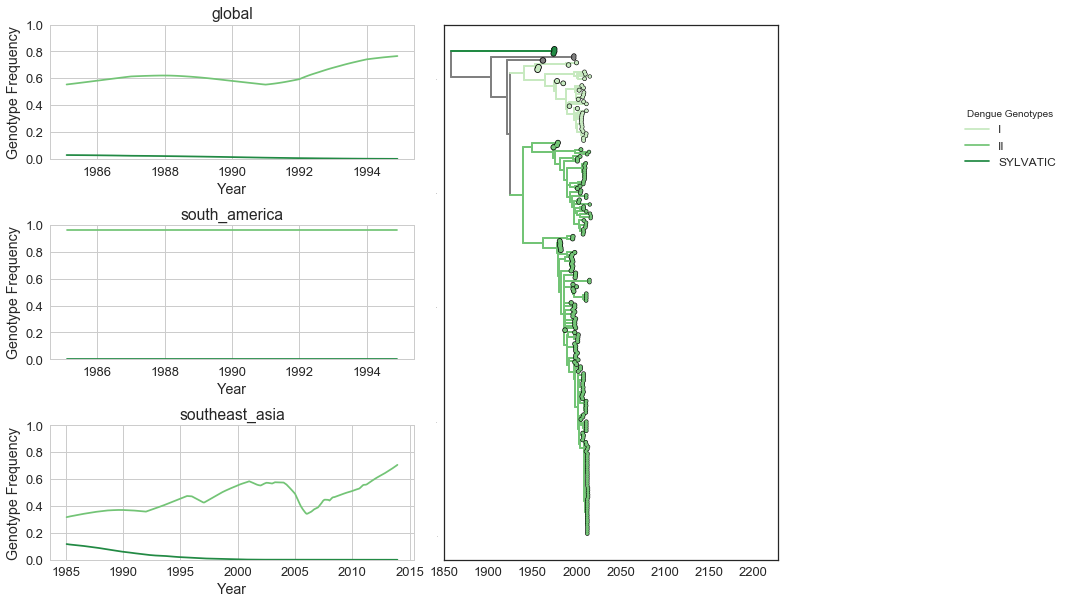

{u'I': 13, u'II': 81, u'SYLVATIC': 1}


In [8]:
plot_frequencies_and_tree()
pprint({g : m.traits['clade'] for g,m in mrcas.items()})

In [22]:
def are_cocirculating(genotype1, genotype2, row):
    return row[genotype1] >= 0.1 and row[genotype2] >= 0.1

def avg_len_cocirculating(flag_series):    
    # first value is a True preceded by a False
    start = flag_series.index[flag_series & ~ flag_series.shift(1).fillna(False)]

    # last value is a True followed by a False
    end = flag_series.index[flag_series & ~ flag_series.shift(-1).fillna(False)]
    time_periods = zip(start, end)
    
    len_cocirculating = [end - start for start,end in time_periods]
    
    avg_len_cocirculating = float(sum(len_cocirculating)) / float(len(len_cocirculating))
    
    return avg_len_cocirculating

def find_dTiter(genotype1, genotype2, region_frequencies, tree=tree):
    pass
    ### Do things here. I might have these values pickled somewhere.............?
    
def compare_prnt_cocirculation_stability(region, region_dfs = region_dfs, tree=tree, genotypes=genotypes):
    genotype_pairs = combinations(genotypes, 2)
    
    prnt = {}
    len_cocirc = {}
    
    for (g1,g2) in genotype_pairs:
        prnt[(g1,g2)] = find_dTiter(g1, g2, region_dfs[region])
        cocirculating_boolean_series = region_dfs[region].apply(lambda x: are_cocirculating(g1,g2,x), axis=1)
        
        len_cocirc[(g1,g2)] = avg_len_cocirculating(cocirculating_boolean_series)
    
    return {'prnt': prnt, 'len_cocirc':len_cocirc}

In [25]:
tmp = compare_prnt_cocirculation_stability('southeast_asia')
prnt = tmp['prnt']
len_cocirc = tmp['len_cocirc']
genotype_pairs = sorted(prnt.keys())

x = [prnt[g] for g in genotype_pairs]
y = [len_cocirc[g] for g in genotype_pairs]

# sns.regplot(x,y)

[(u'I', u'II'), (u'I', u'SYLVATIC'), (u'II', u'SYLVATIC')]
[47.66669999999999, 16.75, 16.75]
